## Лабораторная работа 3. Вариант 1. Протокол - MUB. Размерность гильбертова пространства - 2

In [343]:
import numpy as np
from scipy.stats import bernoulli 
from matplotlib.pyplot import plot,hist,legend
from scipy.linalg import sqrtm
import copy
from scipy.stats import chi2

In [344]:
n_j = 100

## Сгенерируем случайное чистое состояние

In [345]:
def ran_q(d, k):
    psi = (np.random.randn(d * k) + 1j * np.random.randn(d * k))
    psi = psi / np.sqrt((sum(abs(psi) ** 2)))
    psi = np.reshape(psi, (d*k,1))
    ro = np.dot(psi, np.conj(psi).T)
    return psi,ro


In [346]:
psi,ro = ran_q(2,1)
ro

array([[ 0.2589523+2.12069000e-19j, -0.1464289+4.12861457e-01j],
       [-0.1464289-4.12861457e-01j,  0.7410477+2.25306466e-17j]])

## Возьмем функции генерирования статистики, томографии и проецирования на симплекс из предыдущей лабораторной работы.

In [347]:
d = 2
A_0 = np.array([[1,0],[0,1]]) 
A_1 = np.array([[1,1],[1,-1]]) / np.sqrt(2)
A_2 = np.array([[1,1],[1j,-1j]]) / np.sqrt(2)
print(A_0,A_1,A_2,sep = '\n\n')
MUB_2 = [A_0, A_1, A_2]

[[1 0]
 [0 1]]

[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]

[[ 0.70710678+0.j          0.70710678+0.j        ]
 [ 0.        +0.70710678j -0.        -0.70710678j]]


In [348]:
def statistics(state,protocol,n):    
    proj_vec_list = []
    for elem in protocol:
        proj_vec_list.append(elem[:,0].reshape(2,1))
        proj_vec_list.append(elem[:,1].reshape(2,1))
        
    P = []
    for elem in proj_vec_list:
        P.append(np.dot(elem,np.conj(elem).T))
    
    p_list_Born = []
    for elem in P:
        p_list_Born.append(np.real(np.trace(np.dot(elem,state))))
    
    prob_after_born_almost_pure = p_list_Born
        
    counts = []
    for ind in range(0,len(prob_after_born_almost_pure),2):
        experiment = bernoulli.rvs(prob_after_born_almost_pure[ind],size = n)
        counts.append(np.sum(experiment))
        counts.append(n - np.sum(experiment))
        
    prob_counts = [elem/n for elem in counts]
    return counts,prob_counts, p_list_Born

counts_ro, prob_counts,prob_born = statistics(ro,MUB_2,100)

In [349]:
def tomography(protocol,prob_counts):
    
    proj_vec_list = []
    for elem in protocol:
        proj_vec_list.append(elem[:,0].reshape(2,1))
        proj_vec_list.append(elem[:,1].reshape(2,1))
    
    P = []

    for elem in proj_vec_list:
        P.append(np.dot(elem,np.conj(elem).T))
    
    B_part = []
    for elem in P:
        B_part.append(np.hstack((elem[0,:],elem[1,:])))

    B = np.vstack((B_part[0],B_part[1]))
    for ind in range(2,len(B_part)):
        B = np.vstack((B,B_part[ind]))

    u,s,v = np.linalg.svd(B)
    f = np.dot(v,ro.T.reshape(4,1))
    q = np.dot(np.conj(u).T,prob_counts)
    q[5] = 0
    q[4] = 0
    corrected_q = [q[ind]/s[ind] for ind in range(len(f))]
    restored_ro = np.dot(np.conj(v).T,corrected_q).reshape(2,2).T
    return restored_ro

In [350]:
def simplex_project(state):
    eig,vec = np.linalg.eig(state)
    eig_sort = sorted(eig)[::-1]
    w_mem = 0
    for ind in range(1,len(eig_sort)+1):
        w_ind = (np.sum(eig_sort[:ind]) - 1 )/ ind
        if eig_sort[ind-1] - w_ind < 0:
            break
        else:
            w_mem = w_ind 
    new_eig = np.zeros(2)
    for ind in range(len(eig_sort)):
        if eig[ind] - w_mem >= 0:
            new_eig[ind] = eig[ind] - w_mem
    
    return np.dot(np.dot(vec,np.diag(new_eig)),np.conj(vec).T)

## Найдем реконструированное состояние после томографии и проецирования на симплекс. 

In [352]:
ro_0 = simplex_project(tomography(MUB_2,prob_counts))
ro_0

<ipython-input-350-a93500fa1380>:14: ComplexWarning: Casting complex values to real discards the imaginary part
  new_eig[ind] = eig[ind] - w_mem


array([[ 0.26-5.05550202e-18j, -0.13+4.00000000e-01j],
       [-0.13-4.00000000e-01j,  0.74+9.19431703e-21j]])

## Напишем функцию нахождения пси функции из матрицы плотности

In [353]:
def psi_rank(ro,rank):
    d,u = np.linalg.eig(ro)
    d_sort = sorted(d, reverse = True)
    #print(d,d_sort,u)
    if d_sort[0] != d[0]:
        u = np.fliplr(u)  # Меняем порядок столбцов, если был изменен порядок в матрице собственных значений
    #print(u)
    psi = np.dot(u,sqrtm(np.diag(d_sort)))
    if rank == 1:
        return psi[:,0].reshape(2,1)
    else:
        return psi


## Напишем функции нахождения матриц $I$ и $J$

In [357]:
def I_gen(protocol,n_j = 100):    
    proj_vec_list = []
    for elem in protocol:
        proj_vec_list.append(elem[:,0].reshape(2,1))
        proj_vec_list.append(elem[:,1].reshape(2,1))
      
    P = []

    for elem in proj_vec_list:
        P.append(np.dot(elem,np.conj(elem).T))
    return  np.sum(P,axis = 0) * n_j

I = I_gen(MUB_2)
I

array([[300.+0.j,   0.+0.j],
       [  0.+0.j, 300.+0.j]])

In [362]:
def J(protocol,state,counts_ro,n = 100):
    proj_vec_list = []
    for elem in protocol:
        proj_vec_list.append(elem[:,0].reshape(2,1))
        proj_vec_list.append(elem[:,1].reshape(2,1))    
 
    P = []
    for elem in proj_vec_list:
        P.append(np.dot(elem,np.conj(elem).T))
    
    ro = np.dot(state,np.conj(state).T)
    #print(ro)
    _,_,prob_from_J = statistics(ro,protocol,n)
    J_matrix_list = []
   # print(prob_from_J)
    for ind in range(len(P)):
        J_matrix_list.append((counts_ro[ind]/prob_from_J[ind]) * P[ind])
    J_matrix = np.sum(J_matrix_list,axis = 0)
    return J_matrix,prob_from_J

## Функция нахождения нормы Фробениуса

In [363]:
def frobenius_norm(matrix):
    return np.sqrt(np.sum(list(map(lambda x: np.abs(x) ** 2,matrix))))

## Функция MLE

In [364]:
def MLE(ro_0,counts_ro, rank,verbosity = False):    
    eps = 1e-8
    mu = 0.45
    norm = 1
    I_inv = np.linalg.inv(I)
    psi = psi_rank(ro_0, rank)
    while norm >= eps:
        psi_old = psi.copy()
        J_iteration,prob_from_J = J(MUB_2, psi,counts_ro)
        #print(J_iteration)
        psi = (1 - mu)*np.dot(np.dot(I_inv,J_iteration),psi) + mu*psi
        norm = frobenius_norm(psi - psi_old)
        if verbosity == True:
            print(norm,'Текущнее значение нормы разности матриц на соседних итерациях')
    ro_after_MLE = np.dot(psi,np.conj(psi).T)
    if np.abs(1 - np.trace(ro_after_MLE)) > 1e-3:
          ro_after_MLE = simplex_project(ro_after_MLE)
    return ro_after_MLE,prob_from_J
        

## Можно посмотреть за итерациями изменения нормы между двумя соседними шагами для ранга 1 

In [365]:
ro_after_MLE_rank_1,prob_from_J_rank_1 = MLE(ro_0,counts_ro,1,verbosity = True)


0.010111493935683164 Текущнее значение нормы разности матриц на соседних итерациях
0.0017764965278839247 Текущнее значение нормы разности матриц на соседних итерациях
0.0005434677348700386 Текущнее значение нормы разности матриц на соседних итерациях
0.0002377295291354893 Текущнее значение нормы разности матриц на соседних итерациях
0.0001277513701779115 Текущнее значение нормы разности матриц на соседних итерациях
7.458027992756575e-05 Текущнее значение нормы разности матриц на соседних итерациях
4.4594778290879376e-05 Текущнее значение нормы разности матриц на соседних итерациях
2.68273935096761e-05 Текущнее значение нормы разности матриц на соседних итерациях
1.616250309876597e-05 Текущнее значение нормы разности матриц на соседних итерациях
9.740595646183278e-06 Текущнее значение нормы разности матриц на соседних итерациях
5.870740432647853e-06 Текущнее значение нормы разности матриц на соседних итерациях
3.538379477084102e-06 Текущнее значение нормы разности матриц на соседних ите

## Можно посмотреть за итерациями изменения нормы между двумя соседними шагами для ранга 2


In [366]:
ro_after_MLE_rank_2,prob_from_J_rank_2 = MLE(ro_0,counts_ro,2,verbosity = True)


2.354503437443303e-16 Текущнее значение нормы разности матриц на соседних итерациях


## Выведем: 1 - начальная матрица плотности, 2 - после проецирования на симплекс, 3 - после MLE для ранга 1 

In [367]:
print(ro,ro_0,ro_after_MLE_rank_1,sep = '\n\n')

[[ 0.2589523+2.12069000e-19j -0.1464289+4.12861457e-01j]
 [-0.1464289-4.12861457e-01j  0.7410477+2.25306466e-17j]]

[[ 0.26-5.05550202e-18j -0.13+4.00000000e-01j]
 [-0.13-4.00000000e-01j  0.74+9.19431703e-21j]]

[[ 0.24767147+3.95112361e-18j -0.13837637+4.08879315e-01j]
 [-0.13837637-4.08879315e-01j  0.75232853+1.88048852e-19j]]


## Выведем: 1 - начальная матрица плотности, 2 - после проецирования на симплекс, 3 - после MLE для ранга 2

In [368]:
print(ro,ro_0,ro_after_MLE_rank_2,sep = '\n\n')

[[ 0.2589523+2.12069000e-19j -0.1464289+4.12861457e-01j]
 [-0.1464289-4.12861457e-01j  0.7410477+2.25306466e-17j]]

[[ 0.26-5.05550202e-18j -0.13+4.00000000e-01j]
 [-0.13-4.00000000e-01j  0.74+9.19431703e-21j]]

[[ 0.26-5.77760694e-18j -0.13+4.00000000e-01j]
 [-0.13-4.00000000e-01j  0.74-6.36436655e-20j]]


In [369]:
def fidelity(a,b):
    return np.trace(sqrtm(np.dot(np.dot(sqrtm(a),b),sqrtm(a)))) ** 2

## Выведем: 1 - точность между начальным и спроецированным на симплекс, 2 - точность между начальным и после MLE состояниями для ранга 1

In [370]:
print(fidelity(ro_0,ro),fidelity(ro_after_MLE_rank_1,ro))

(0.984063579095504+2.587326614688819e-09j) (0.9997920544222957-7.495614695653053e-09j)


## Выведем: 1 - точность между начальным и спроецированным на симплекс, 2 - точность между начальным и после MLE состояниями для ранга 2

In [371]:
print(fidelity(ro_0,ro),fidelity(ro_after_MLE_rank_2,ro))

(0.984063579095504+2.587326614688819e-09j) (0.9840635810352237+7.174709920240621e-09j)


## Напишем функцию нахождения значения теста  хи квадрат

In [372]:
def chi_square_gen(state, real_counts_from_exp_ro,prob_from_J):
    n_j = 100
    chi = 0
    #print(state)
    #_,_,prob = statistics(state,MUB_2,n = 100)
    #print(counts_ro)
    for ind in range(len(prob_from_J)):
        chi += ((real_counts_from_exp_ro[ind] - n_j*prob_from_J[ind]) ** 2) / (n_j*prob_from_J[ind])
    return chi

## Найдем кол-во независимых и общее кол-во степеней свободы

## Для ранга 1

In [375]:
d = 2
def nu_p(rank):
    return (2*d - rank)*rank - 1 
print('Число независимых степеней свободы с рангом 1:',nu_p(1))

Число независимых степеней свободы с рангом 1: 2


In [376]:
def nu(rank):
    m = 6
    m_b = 3
    return m - m_b - nu_p(rank)
print('Общее число независимых степеней свободы с рангом 1:',nu(1))

Общее число независимых степеней свободы с рангом 1: 1


## Для ранга 2 

In [377]:
def nu_p(rank):
    return (2*d - rank)*rank - 1 
print('Число независимых степеней свободы с рангом 2:',nu_p(2))

Число независимых степеней свободы с рангом 2: 3


In [378]:
def nu(rank):
    m = 6
    m_b = 3
    return m - m_b - nu_p(rank)
print('Общее число независимых степеней свободы с рангом 2:',nu(2))

Общее число независимых степеней свободы с рангом 2: 0


## Можно сделать вывод, что для протокола MUB с размерностью пространства $d = 2$, нехватает степеней свободы для нахождения $p-value$ c рангом состояния $rank = 2$

## Построим гистограммы $p-value$ и точности 

In [380]:
def p_value(N = 1000):
    p_value_list = []
    fidel_list = []
    fidel_list_rank_2 = []
    fidel_simplex_list= []
    for ind in range(N):
        _,ro_p_value = ran_q(2,1)
        counts_ro_p_value, prob_counts_p_value,_ = statistics(ro_p_value,MUB_2,100)
        ro_0_p_value = simplex_project(tomography(MUB_2,prob_counts_p_value))
        ro_after_MLE_ind_p_value, prob_from_J = MLE(ro_0_p_value,counts_ro_p_value,1,verbosity = False)
        ro_after_MLE_ind_p_value_rank_2, prob_from_J_rank_2 = MLE(ro_0_p_value,counts_ro_p_value,2,verbosity = False)

        chi_square= chi_square_gen(ro_after_MLE_ind_p_value,counts_ro_p_value,prob_from_J)
        p_value_list.append(1 - chi2.cdf(chi_square,nu(1)))
        fidel_list.append(fidelity(ro_after_MLE_ind_p_value,ro_p_value))
        fidel_list_rank_2.append(fidelity(ro_after_MLE_ind_p_value_rank_2,ro_p_value))
        #print(fidel_list_rank_2)
        fidel_simplex_list.append(fidelity(ro_0_p_value,ro_p_value))
    return p_value_list,fidel_list,fidel_simplex_list,fidel_list_rank_2

<ipython-input-350-a93500fa1380>:14: ComplexWarning: Casting complex values to real discards the imaginary part
  new_eig[ind] = eig[ind] - w_mem


(array([34., 39., 34., 33., 50., 43., 48., 36., 35., 44., 42., 40., 49.,
        34., 41., 40., 41., 39., 38., 40., 32., 39., 38., 49., 42.]),
 array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
        0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
        0.88, 0.92, 0.96, 1.  ]),
 <BarContainer object of 25 artists>)

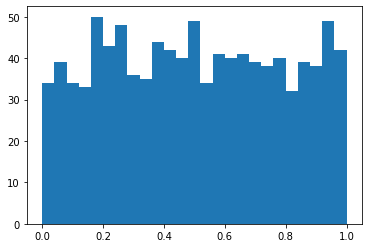

In [381]:
p_value_list, fidel_list, fidel_simplex_list, fidel_list_rank_2 = p_value()
hist(p_value_list,bins = 25,range=(0,1))


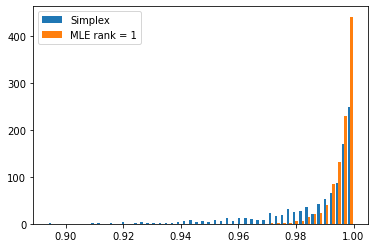

In [384]:
hist([fidel_simplex_list,fidel_list],bins = 50,label = ['Simplex','MLE rank = 1'])
legend(loc='upper left')
#hist(fidel_simplex_list,bins = 50,label = 'y')

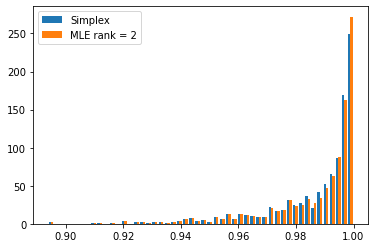

In [385]:
hist([fidel_simplex_list,fidel_list_rank_2],bins = 50,label = ['Simplex','MLE rank = 2'])
legend(loc='upper left')

## Создадим функции перехода в действительное Евклидово пространство 

In [386]:
def psi_euqlid(state):
    return np.vstack((np.real(state),np.imag(state)))

In [387]:
def P_j_euqlid(P_j):
    Re = np.real(P_j)
    Im = np.imag(P_j)
    return np.block([[Re, -Im],[Im, Re]])

In [388]:
psi_column = psi_euqlid(psi)

## Создадим функцию полной информации

In [389]:
def H_gen(protocol):
    proj_vec_list = []
    for elem in protocol:
        proj_vec_list.append(elem[:,0].reshape(2,1))
        proj_vec_list.append(elem[:,1].reshape(2,1))        
    P = []
    for elem in proj_vec_list:
        P.append(np.dot(elem,np.conj(elem).T))
    
    
    H = np.zeros((4,4), dtype = complex)
    for ind in range(len(prob_counts)):
        H += 2* (n_j/prob_counts[ind]) * np.dot((np.dot(P_j_euqlid(P[ind]),psi_column)),(np.dot(P_j_euqlid(P[ind]),psi_column)).T)
    return H

In [390]:
H = H_gen(MUB_2)

## Найдем собственные значения матрицы полной информации и занулим максимальное и минимальное значения

In [391]:
eig,_ = np.linalg.eig(H)
eig

array([ 6.00783195e+02+0.j,  3.47782328e+02+0.j,  2.24381940e+02+0.j,
       -5.38326314e-14+0.j])

In [392]:
max_elem = max(eig)
for ind in range(len(eig)):
    if eig[ind] < 1e-8 or eig[ind] == max_elem:
        eig[ind] = 0 
eig

array([  0.        +0.j, 347.7823278 +0.j, 224.38194023+0.j,
         0.        +0.j])

## Найдем средние потери точности и дисперсию

In [393]:
av_infidelity = sum(list(map(lambda x: 1/(2*x),list(filter(lambda x:x != 0,eig)))))

In [394]:
var = 2*sum([(1/(2*d))**2 for d in eig if d != 0])

In [395]:
print('Средние потери точности равны:',av_infidelity,'. Дисперсия равна',var)

Средние потери точности равны: (0.003666024201642071+0j) . Дисперсия равна (1.4064880571680381e-05+0j)


## Найдем выборочные средние потери точности и дисперсию

In [396]:
av_infidelity_exp = np.sum([1 - elem for elem in fidel_list]) /1000

In [397]:
print('Выборочные средние потери точности:',av_infidelity_exp)

Выборочные средние потери точности: (0.003933898408628035+1.0635127860893374e-10j)


In [398]:
var_infidelity_exp = np.var([1 - elem for elem in fidel_list])

In [399]:
print('Выборочная дисперсия:',var_infidelity_exp)

Выборочная дисперсия: 1.7497761841803746e-05
